In [1]:
# Import relevant libraries.
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elif.ozkol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elif.ozkol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\elif.ozkol\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\elif.ozkol\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_excel('C:\\Users\\elif.ozkol\\Desktop\\LSE Project\\CleanedDataUK.xlsx')

df

,Reference,Country,Date,Year,Month,Title,Author,IsGov,Text
0,r980915a_BOE,United Kingdom,1998-09-15,1998,September,Speech,George,Yes,"Thank you, Chairman. I'm actually very pleased..."
1,r981021b_BOE,United Kingdom,1998-10-21,1998,October,Britain in Europe,George,Yes,It's a great pleasure to be here in the beauti...
2,r981021a_BOE,United Kingdom,1998-10-21,1998,October,Impact of the recent turbulence in internation...,King,No,Few industries have suffered more from volatil...
3,r981101a_BOE,United Kingdom,1998-11-01,1998,November,"Economic policy, with and without forecasts",Budd,No,My topic this evening is the use of forecasts ...
4,r981101b_BOE,United Kingdom,1998-11-01,1998,November,Inflation targeting in practice: the UK experi...,Vickers,No,"Six years ago this week, sterling left the exc..."
...,...,...,...,...,...,...,...,...,...
1204,r220428a_BOE,United Kingdom,2022-04-28,2022,April,Macropru,Breeden,No,Dimitri Demekas and Paul Tucker for helpful di...
1205,r220426a_BOE,United Kingdom,2022-04-26,2022,April,Bufferati,Woods,No,Copies of publications are available from: Thi...
1206,r220503a_BOE,United Kingdom,2022-05-03,2022,May,Why macroprudential policy needs to tackle fin...,Stheeman,No,Elisabeth Stheeman notes that climate change a...
1207,r221019a_BOE,United Kingdom,2022-10-19,2022,October,"Governance of “Decentralised” Finance: Get up,...",Wilkins,No,"These are divided into seven categories, suffr..."


In [3]:
# Create a new data frame for the file sentiment labelled wordlist

df_sentiment_words = pd.read_excel('C:\\Users\\elif.ozkol\\Desktop\\LSE Project\\LSE_DA_BoE_Employer_project_Sentiment-labelled_wordlist-2.xlsx')

df_sentiment_words

,Word,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
0,ABANDON,1,0,0,0,0,0,0
1,ABANDONED,1,0,0,0,0,0,0
2,ABANDONING,1,0,0,0,0,0,0
3,ABANDONMENT,1,0,0,0,0,0,0
4,ABANDONMENTS,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
3875,WRONGDOINGS,1,0,0,0,0,0,0
3876,WRONGFUL,1,0,0,0,0,0,0
3877,WRONGFULLY,1,0,0,0,0,0,0
3878,WRONGLY,1,0,0,0,0,0,0


**Build the Custom Lexicon:**

In [4]:
# Force all entries in 'Word' column to strings, skipping bad ones
df_sentiment_words = df_sentiment_words[df_sentiment_words['Word'].apply(lambda x: isinstance(x, str))]

df_sentiment_words

,Word,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
0,ABANDON,1,0,0,0,0,0,0
1,ABANDONED,1,0,0,0,0,0,0
2,ABANDONING,1,0,0,0,0,0,0
3,ABANDONMENT,1,0,0,0,0,0,0
4,ABANDONMENTS,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
3874,WRONGDOING,1,0,0,0,0,0,0
3875,WRONGDOINGS,1,0,0,0,0,0,0
3876,WRONGFUL,1,0,0,0,0,0,0
3877,WRONGFULLY,1,0,0,0,0,0,0


In [5]:
custom_lexicon = {}

for _, row in df_sentiment_words.iterrows():
    word = row['Word'].lower()
    
    # Weighted score based on categories
    score = (
        row['Positive'] * 2.0 +
        row['Negative'] * -2.0 +
        row['Uncertainty'] * -0.5 +
        row['Litigious'] * -0.3 +
        row['Strong'] * 1.0 +
        row['Weak'] * -1.0 +
        row['Constraining'] * -0.5
    )
    
    # Only include non-zero scores
    if score != 0:
        custom_lexicon[word] = score

**Define an NLTK-based analyzer using the lexicon**

In [19]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')  # Only needs to run once

def analyze_sentiment(text, lexicon):
    tokens = word_tokenize(str(text).lower())
    score = sum(lexicon.get(word, 0) for word in tokens)
    
    pos_words = [w for w in tokens if lexicon.get(w, 0) > 0]
    neg_words = [w for w in tokens if lexicon.get(w, 0) < 0]

    return {
        "SentimentScore": score,
        "PositiveCount": len(pos_words),
        "NegativeCount": len(neg_words),
        "TotalWords": len(tokens)
    }



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elif.ozkol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Apply to the DataFrame**

In [20]:
# Apply sentiment analysis to each row in the 'Text' column
sentiment_results = df['Text'].apply(lambda text: analyze_sentiment(text, custom_lexicon))

# Convert results (dicts) into separate columns
sentiment_df = sentiment_results.apply(pd.Series)

# Merge back into original DataFrame
df = pd.concat([df, sentiment_df], axis=1)


In [21]:
df

,Reference,Country,Date,Year,Month,Title,Author,IsGov,Text,SentimentScore,PositiveCount,NegativeCount,TotalWords
0,r980915a_BOE,United Kingdom,1998-09-15,1998,September,Speech,George,Yes,"Thank you, Chairman. I'm actually very pleased...",-51.9,56.0,87.0,2639.0
1,r981021b_BOE,United Kingdom,1998-10-21,1998,October,Britain in Europe,George,Yes,It's a great pleasure to be here in the beauti...,-36.8,121.0,152.0,4397.0
2,r981021a_BOE,United Kingdom,1998-10-21,1998,October,Impact of the recent turbulence in internation...,King,No,Few industries have suffered more from volatil...,-89.6,44.0,107.0,2551.0
3,r981101a_BOE,United Kingdom,1998-11-01,1998,November,"Economic policy, with and without forecasts",Budd,No,My topic this evening is the use of forecasts ...,-131.8,70.0,186.0,5213.0
4,r981101b_BOE,United Kingdom,1998-11-01,1998,November,Inflation targeting in practice: the UK experi...,Vickers,No,"Six years ago this week, sterling left the exc...",-213.3,61.0,240.0,5082.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,r220428a_BOE,United Kingdom,2022-04-28,2022,April,Macropru,Breeden,No,Dimitri Demekas and Paul Tucker for helpful di...,-129.7,75.0,161.0,3361.0
1205,r220426a_BOE,United Kingdom,2022-04-26,2022,April,Bufferati,Woods,No,Copies of publications are available from: Thi...,-374.8,60.0,356.0,5651.0
1206,r220503a_BOE,United Kingdom,2022-05-03,2022,May,Why macroprudential policy needs to tackle fin...,Stheeman,No,Elisabeth Stheeman notes that climate change a...,-16.5,40.0,90.0,2227.0
1207,r221019a_BOE,United Kingdom,2022-10-19,2022,October,"Governance of “Decentralised” Finance: Get up,...",Wilkins,No,"These are divided into seven categories, suffr...",20.0,121.0,147.0,5890.0


Final df will now include:
SentimentScore — weighted sum based on your lexicon

PositiveCount — number of positive words

NegativeCount — number of negative words

TotalWords — total token count

In [22]:
# Group by Year and aggregate
df_grouped = df.groupby('Year').agg({
    'SentimentScore': 'mean',
    'PositiveCount': 'sum',
    'NegativeCount': 'sum',
    'TotalWords': 'sum'
}).reset_index()

df_grouped

,Year,SentimentScore,PositiveCount,NegativeCount,TotalWords
0,1998,-117.425000,613.0,1303.0,33581.0
1,1999,-98.340000,2230.0,4623.0,122003.0
2,2000,-32.169444,2723.0,4128.0,118736.0
3,2001,-102.025000,3035.0,6318.0,145713.0
4,2002,-81.183333,2203.0,4215.0,110548.0
5,2003,-103.847368,1320.0,2923.0,78663.0
6,2004,-87.807143,1788.0,3956.0,105182.0
7,2005,-81.367857,1778.0,3807.0,102623.0
8,2006,-82.958824,2119.0,4547.0,121608.0
9,2007,-89.394286,2873.0,5662.0,161003.0


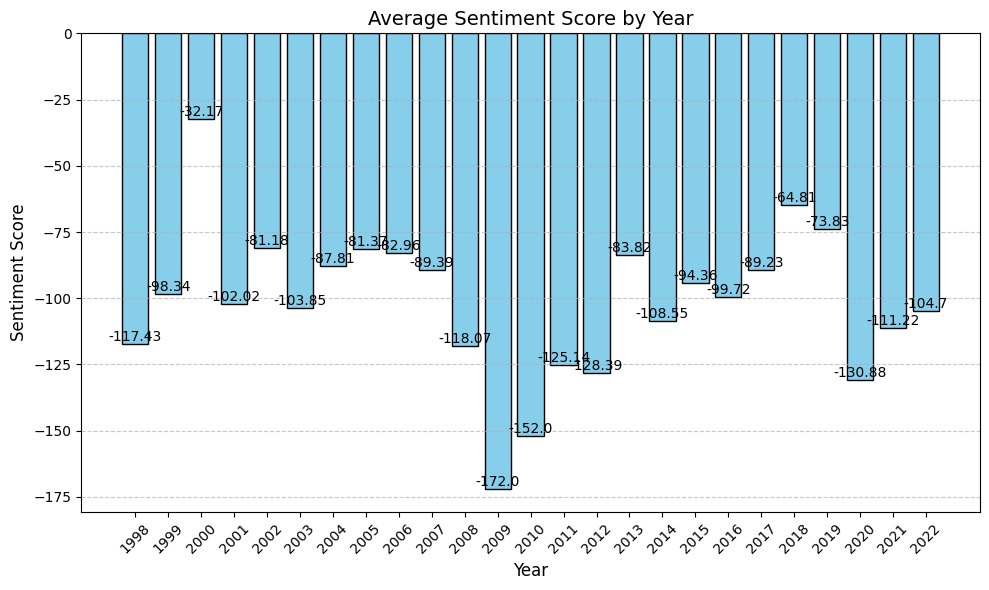

In [24]:
# visualization with clearer year labels
plt.figure(figsize=(10, 6))

bars = plt.bar(df_grouped['Year'].astype(str), df_grouped['SentimentScore'], color='skyblue', edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.title('Average Sentiment Score by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

